# CatBoost

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Args

In [2]:
INPUT_DATA = 'test.csv'
IS_TRAIN = False
SAVE_PATH = 'model.cb'

## Examine data

In [3]:
%%capture
df = pd.read_csv(INPUT_DATA, sep='\t', error_bad_lines=False, header=0)

In [4]:
df.shape

(39155, 108)

In [5]:
df.head()

,Unnamed: 0,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,...,phyloP100way_vertebrate,phyloP100way_vertebrate_rankscore,phyloP20way_mammalian,phyloP20way_mammalian_rankscore,phastCons100way_vertebrate,phastCons100way_vertebrate_rankscore,phastCons20way_mammalian,phastCons20way_mammalian_rankscore,SiPhy_29way_logOdds_rankscore,MIM_disease
0,0,1,368335,G,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,877831,T,C,NM_015658.3,NaN,downstream,p.?,82.5923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,877831,T,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,879676,G,A,NM_015658.3,NaN,3'UTR,p.?,82.5923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,879676,G,A,NM_152486.2,NaN,3'UTR,p.?,88.4961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### Filters

In [6]:
RELEVANT_FEATURES = [
    'chrom',
    'inputPos',
    'inputRef',
    'inputAlt',
    'transcript',
    'codingEffect',
    'varLocation',
    'alt_pNomen',
    'wtSSFScore',
    'wtMaxEntScore',
    'varSSFScore',
    'varMaxEntScore',
#     'rsId',
#     'rsClinicalSignificance',
    'rsMAF',
    '1000g_AF',
    'gnomadAltFreq_all',
    'espAllMAF',
    'espAllAAF',
    'clinVarMethods',
    'clinVarClinSignifs',
    'nOrthos',
    'conservedOrthos'
] + [column for column in df.columns if 'score' in column] + ['MIM_disease']


RULES = [
    lambda df: df['codingEffect'] != 'synonymous',
    lambda df: df['varLocation'] != 'intron',
    lambda df: np.invert(df['1000g_AF'] > 0.01),
    lambda df: np.invert(df['gnomadAltFreq_all'] > 0.01)
]


def rules_filter(df):
    for rule in RULES:
        df = df[rule(df)]
    return df

In [7]:
def pre_robust(df):
    df = df[RELEVANT_FEATURES]  # Filtering relevant features
    df = rules_filter(df)  # Rules filtering
    return df

### `inputPos` as regression parametr

In [8]:
def pre_pos(df):
    df = df.copy()
    df.inputPos = df.inputPos.astype(float)
    return df

### `clinVarMethods` split

In [9]:
CVM_METHODS = {
    'case-control': 0,
    'clinical_testing': 1,
    'curation': 2,
    'in_vitro': 3,
    'in_vivo': 4,
    'literature_only': 5,
    'not_provided': 6,
    'phenotyping_only': 7,
    'provider_interpretation': 8,
    'reference_population': 9,
    'research': 10,
    'nan': 11
}


def fetch_names(row, delimeters='|,'):
    def unify(name):
        return '_'.join(name.strip().lower().split())
    
    names = [row]
    for delimeter in delimeters:
        new_names = []
        for name in names:
            new_names.extend(name.split(delimeter))
        names = new_names
    return [unify(name) for name in names]


def collect_names(column, delimeters='|,'): 
    all_names = set()
    for row in column:
        all_names.update(set(fetch_names(row)))
    return all_names

In [10]:
def pre_cvm(df):
    df = df.copy()
    
    df.clinVarMethods = df.clinVarMethods.fillna('nan')
    cvm_features = []
    for row in df.clinVarMethods:
        row_features = np.zeros(len(CVM_METHODS))
        for name in fetch_names(row):
            row_features[CVM_METHODS[name]] += 1
        cvm_features.append(row_features)
    cvm_features = np.vstack(cvm_features)
    
    cvm_columns = ['cvm_' + m for _, m in sorted([(i, m) for m, i in CVM_METHODS.items()])]
    cvm_features = pd.DataFrame(cvm_features, columns=cvm_columns, index=df.index)
    df = pd.concat([df, cvm_features], axis=1)
    del df['clinVarMethods']
    return df

### All

In [11]:
PRES = [
    pre_robust,
    pre_pos,
    pre_cvm
]


def pre_all(df):
    for pre in PRES:
        df = pre(df)
    return df

In [12]:
df = pre_all(df)
df.shape

(4897, 83)

## Making target

In [13]:
RELEVANCES = {
    'benign': 0, 
    'likely_benign': 1, 
    'not_provided': 2, 
    'vus': 2, 
    'likely_pathogenic': 3, 
    'pathogenic': 4
}


def labelize_row(row):
    return max((RELEVANCES[name] for name in fetch_names(row) if name in RELEVANCES), default=2)


def labelize_target(y, bad_word='pathogenic'):
    return y.apply(labelize_row)

## NDCG

In [14]:
def split_relevance(relevance):
    return [r.lower() for it in relevance.split('|') for r in it.split(', ') if r.lower() in RELEVANCES]


def get_relevances(significances):
    return [split_relevance(significance) for significance in significances.values]


def dcg(relevances):
    return np.sum(2 ** relevances / np.log2(np.arange(2, relevances.size + 2)))


def evaluate_serp(df, sign, score, n=30):
    serp = df.sample(n=n, replace=False)
    rel_true = np.array([RELEVANCES[np.random.choice(sign[index], size=1)[0]] for index, row in serp.iterrows()])

    order_true = np.argsort(rel_true)[::-1]
    serp = serp.iloc[order_true]
    rel_true = rel_true[order_true]

    order_pred = np.argsort(score[serp.index])[::-1]
    rel_pred = rel_true[order_pred]
    
    return dcg(rel_pred) / dcg(rel_true)


def evaluate(df, sign, score, k=1000, n=30):
    np.random.seed(42)
    return np.mean([evaluate_serp(df, sign, score, n) for _ in range(k)])

## TT split

In [15]:
def tt_split(df, is_train):
    np.random.seed(42)
    df = df.copy()
    
    df.rename({'clinVarClinSignifs': 'y'}, axis=1, inplace=True)
    del df['MIM_disease']
    df = df.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
    
    if is_train:
        df = df.loc[df.y.notna()]
        sign = pd.Series(data=get_relevances(df.y), index=df.index)
        not_empty = [it != [] for it in sign]
        df = df[not_empty]
        sign = sign[not_empty]
        y = labelize_target(df.y)
        
        del df['y']
        X = df
        
        X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_validate, y_train, y_validate = train_test_split(X_, y_, test_size=0.2)
        data = (X_train, y_train), (X_validate, y_validate), (X_test, y_test)
        cat_features = np.where(X.dtypes != np.float)[0]
        return data, cat_features, sign
    else:
        del df['y']
        X = df
        cat_features = np.where(X.dtypes != np.float)[0]
        return X.sample(frac=1), cat_features

In [16]:
if IS_TRAIN:
    data, cat_features, sign = tt_split(df, is_train=True)
    (X_train, y_train), (X_validate, y_validate), (X_test, y_test) = data
    print('TRAIN', X_train.shape, X_validate.shape, X_test.shape)
else:
    X, cat_features = tt_split(df, is_train=False)
    print('TEST', X.shape)

TEST (4897, 81)


## Train

In [17]:
model = cb.CatBoostClassifier(iterations=300, loss_function='MultiClass')
if IS_TRAIN:
    model.fit(X_train, y_train, cat_features=cat_features, 
              use_best_model=True, eval_set=(X_validate, y_validate),
              plot=False);
    model.save_model(SAVE_PATH)
else:
    model.load_model(SAVE_PATH)

## Test

In [18]:
def calc_score(model, df):
    return model.predict(df)[:, 0] + model.predict_proba(df).max(axis=1)

In [19]:
if IS_TRAIN:
    precision = (model.predict(X_test)[:, 0] == y_test).sum() / len(y_test)
    score = pd.Series(data=calc_score(model, X_test), index=X_test.index)
    ndcg = evaluate(X_test, sign, score)
    print(f'precision={precision} ndcg={ndcg}')

## Analysis

In [20]:
model.get_params()

{'iterations': 300, 'loss_function': 'MultiClass', 'use_best_model': True}

In [21]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [22]:
if IS_TRAIN:
    draw_importance(X_train.columns, model.feature_importances_, save_path=None)

In [23]:
if IS_TRAIN:
    sns.distplot(y_test, kde=False);
    sns.distplot(y_train, kde=False);

## Final flow

1. Filter out all `y` $\in [0, 1]$.
2. Sort `codingEffect` (all but misence) according to score values.
3. Sort all misence data (score) and append to back.

In [24]:
def final_order(model, df):
    df = df.copy()
    
    df['y'] = model.predict(df)[:, 0].astype(int)
    df = df[np.invert((df.y == 0) | (df.y == 1))]
#     del df['y']
    
    df['score'] = -calc_score(model, df)
    df['isCodingEffect'] = (df.codingEffect == 'missense').astype(int)
    df = df.sort_values(by=['isCodingEffect', 'score'])
    del df['score']
#     df['score'] = -df['score']
    del df['isCodingEffect']
    
    return df

In [25]:
X_test = X_test if IS_TRAIN else X
of = final_order(model, X_test)
X_test.shape, of.shape  # Plus `y` column

((4897, 81), (4778, 82))

## FF analysis

In [26]:
of.head()

,chrom,inputPos,inputRef,inputAlt,transcript,codingEffect,varLocation,alt_pNomen,wtSSFScore,wtMaxEntScore,...,cvm_in_vitro,cvm_in_vivo,cvm_literature_only,cvm_not_provided,cvm_phenotyping_only,cvm_provider_interpretation,cvm_reference_population,cvm_research,cvm_nan,y
38698,X,70361131.0,C,T,NM_005120.2,stop gain,exon,p.Gln2107*,84.7676,8.76550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
38831,X,118603706.0,A,AG,NM_001152.4,frameshift,exon,p.Val67Serfs*8,83.0572,9.50524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
5780,11,1017041.0,G,T,NM_005961.2,stop gain,exon,p.Tyr1920*,91.0858,10.91170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
10395,12,112846290.0,A,T,NM_000970.4,stop gain,exon,p.Tyr57*,94.6745,10.51230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
27413,3,75787490.0,A,T,NM_001128223.2,stop gain,exon,p.Cys428*,91.5892,9.84865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4


In [27]:
of.y.value_counts()

2    4673
4     105
Name: y, dtype: int64

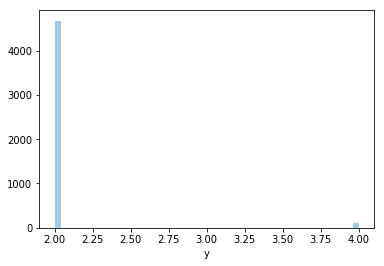

In [28]:
sns.distplot(of.y, kde=False);

In [29]:
np.where(of.y == 4)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278,
        3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289,
        3290, 3291, 3292, 3293, 3294, 3295]),)

In [30]:
of[of.y == 4].codingEffect.value_counts()

stop gain     36
missense      27
NaN           24
frameshift    18
Name: codingEffect, dtype: int64